In [1]:
import pandas as pd 
import numpy as np

import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_domains, si_tracks, si_proteins, si_sites
from shephard.tools import domain_tools
from shephard.sequence_utilities import mega_string 

In [2]:

###
### PLOTTING SETTINGS ####
###

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

## conversion dictionaries 
AA_letter_to_code = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly', 'H': 'His','I': 'Ile',
                     'L': 'Leu','K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}

## custom color palettes
AA_type_palette={'A':'#000000','I':'#000000','L':'#000000','M':'#000000','V':'#000000',
                 'F':'#f2a139','Y':'#f2a139','W':'#f2a139',
                 'D':'#eb3628','E':'#eb3628',
                 'R':'#201beb','K':'#201beb',
                 'P':'#bf42b2','C':'#fbe74f',
                 'N':'#306e22','Q':'#306e22','G':'#306e22','S':'#306e22','T':'#306e22','H':'#306e22'}

location_palette = {'SA_fd_sites':'#c7c6b5', 'idr_sites':'#61aced'}

auto_ptm_palette = {'Phosphoserine': '#e0d82f', 'Phosphothreonine': '#e0d82f', 'Phosphotyrosine': '#e0d82f',
                    'Ubiquitination': '#d487d6', 'N6-acetyllysine': '#2294f2',  'N-Glycosylation': '#6b2424',
                    'Methylation': '#154d20', 'Sumoylation': '#8d5fa3', 'Dimethylation': '#154d20',
                    'O-Glycosylation': '#6b2424', 'Omega-N-methylarginine': '#154d20', 'N6-succinyllysine': '#2e2e2e',
                    'N-acetylalanine': '#2294f2', 'N-acetylmethionine': '#2294f2','S-nitrosocysteine': '#2e2e2e',
                    'N6,N6-dimethyllysine': '#154d20', 'Asymmetric dimethylarginine': '#154d20','Y': '#a1a1a1',
                    'A': '#a1a1a1','N': '#a1a1a1','R': '#a1a1a1','K': '#a1a1a1','R_K_H': '#a1a1a1','M': '#a1a1a1',
                    'T_S': '#a1a1a1','C': '#a1a1a1','T': '#a1a1a1','S': '#a1a1a1'}

### Read in Data

In [3]:
print('Reading in human proteome...')
af2_prot = shephard.proteome.Proteome([])
si_proteins.add_proteins_from_file(af2_prot,'../shprd_data/shprd_proteins_filtered_human_af2_f1acc.tsv')

print('Reading in all af2 sasa tracks...')
si_tracks.add_tracks_from_file(af2_prot, '../shprd_data/shprd_tracks_filtered_af2_f1_solv_acc.tsv', mode='values')

print('Reading in all IDRs...')
si_domains.add_domains_from_file(af2_prot, '../shprd_data/shprd_domains_human_IDRs_0.420.tsv')

print('Reading in all PTMs...')
si_sites.add_sites_from_file(af2_prot, '../shprd_data/shprd_sites_filtered_proteomescout.tsv')

Reading in human proteome...
Reading in all af2 sasa tracks...
Reading in all IDRs...
Reading in all PTMs...


In [4]:
# define PTMs of intrest and their targeting residues 
PTM_target_dict = {'Phosphoserine': ['S'], 'Phosphothreonine': ['T'], 'Phosphotyrosine': ['Y'], 
                   'Ubiquitination': ['K'], 'N6-acetyllysine': ['K'], 'N-Glycosylation': ['N'], 
                   'Methylation': ['R', 'K', 'H'], 'Sumoylation': ['K'], 'Dimethylation': ['R'],
                   'O-Glycosylation': ['T', 'S'], 'Omega-N-methylarginine': ['R'], 'N6-succinyllysine': ['K'], 
                   'N-acetylalanine': ['A'], 'N-acetylmethionine': ['M'], 'S-nitrosocysteine': ['C'], 
                   'N6,N6-dimethyllysine': ['K'], 'Asymmetric dimethylarginine': ['R']}

# build list of potential target residues
targets = list(set([r for item in PTM_target_dict.items() for r in item[1]]))

### Analysis of all annotated sites for IDR location and Solvent accessibility

In [5]:
# annotate any solvent accessible PTMs  
# here solvent accessable is defined as af2_SAS > 10 
for s in af2_prot.sites:
    # check if site is solvent accesable 
    if s.get_track_values('af2_f1_solv_acc', offset=0)[0] > 10:
        s.add_attribute('af2_SA', True)

# annotate any sites in IDRS 
for d in af2_prot.domains:
    if d.domain_type == 'IDR':
        for s in d.sites:
            s.add_attribute('in_IDR', True)

In [6]:
# iterate all PTMs and get data 
for ptm_type in PTM_target_dict:
    
    # only extract data and save as attributes if data hasnt been 
    # annontated - this is needed because some PTMs have the same targets
    if "ana_%s_data" % ptm_type not in af2_prot.attributes:

        sites_of_intrest = [s for s in af2_prot.sites if s.site_type == ptm_type]
        idr_ptms = []
        fd_ptms = []
        SA_fd_ptms = []

        for s in sites_of_intrest:
            if 'in_IDR' in s.attributes:
                idr_ptms.append(s)

            else:
                fd_ptms.append(s)

                if 'af2_SA' in s.attributes:
                    SA_fd_ptms.append(s)

        af2_prot.add_attribute("ana_%s_data" % ptm_type, {'sites_of_intrest':len(sites_of_intrest), 
                                                      'idr_sites':len(idr_ptms),
                                                      'fd_sites':len(fd_ptms),
                                                      'SA_fd_sites':len(SA_fd_ptms),
                                                      'target_data': "_".join(PTM_target_dict[ptm_type])})



### Analysis for PTM target residues

In [7]:
# build and annotate megastring of proteome 
af2_prot.add_attribute('mega_string_prot', mega_string(af2_prot))

# build and annotate megastring of IDR domains 
af2_prot.add_attribute('mega_string_IDR', mega_string(af2_prot.domains))

In [8]:
# build dictionary of annotated PTM target residues
site_stat_dict = {s_type:{'sites_of_intrest':0, 
                          'idr_sites':0, 'fd_sites':0, 
                          'SA_fd_sites':0} for s_type in targets}  
# iterate target residues 
for s in targets:
    
    print("getting stats for %s..." % s)
    # get total count of residue sites 
    site_stat_dict[s]['sites_of_intrest'] = af2_prot.attribute('mega_string_prot').count(s)
    
    # get total count of residue sites in IDRs 
    site_stat_dict[s]['idr_sites'] = af2_prot.attribute('mega_string_IDR').count(s)
    
    # get total count of residue sites in folded domains  
    site_stat_dict[s]['fd_sites'] = site_stat_dict[s]['sites_of_intrest'] - site_stat_dict[s]['idr_sites']
    
    
# iterate and count all solvent accessable sites in All Folded domains in the human proteome
cc=0
for p in af2_prot:
    local_track = p.get_track_values('af2_f1_solv_acc')
    for s in targets: 
        # iterate found targets
        for s_p in sequence_tools.find_all_indicies(p.sequence,s):
            # check if target is in solvent accessable
            if local_track[s_p] > 10:
                # check if in folded domain
                in_idr = False
                # (add 1 to s_p as SHEPHARD indexes from 1)
                for d in p.get_domains_by_type('IDR'):
                    if d.start <= s_p+1 <= d.end:
                        in_idr = True 
                
                if not in_idr:
                    site_stat_dict[s]['SA_fd_sites'] +=1 
    
    # return progress
    cc+=1                
    if cc in [1000,10000,15000,20000,25000]:
        print("On protein %i..." % cc)

getting stats for A...
getting stats for S...
getting stats for Y...
getting stats for T...
getting stats for C...
getting stats for R...
getting stats for M...
getting stats for K...
getting stats for H...
getting stats for N...
On protein 1000...
On protein 10000...
On protein 15000...
On protein 20000...


In [9]:
# add stats for sets of targets as proteome attributes 
target_name_list = []
for ptm_type in PTM_target_dict:
    
    target_name = "_".join(PTM_target_dict[ptm_type])
    target_name_list.append(target_name)
    
    # check to see if target set is annoteded
    if "ana_%s_data" % target_name not in af2_prot.attributes:
        
        # get sum of the value for all of the residues in the target list for the PTM 
        sites_of_intrest = sum([site_stat_dict[t]['sites_of_intrest'] for t in PTM_target_dict[ptm_type]])
        idr_sites = sum([site_stat_dict[t]['idr_sites'] for t in PTM_target_dict[ptm_type]])
        fd_sites = sum([site_stat_dict[t]['fd_sites'] for t in PTM_target_dict[ptm_type]])
        SA_fd_sites = sum([site_stat_dict[t]['SA_fd_sites'] for t in PTM_target_dict[ptm_type]])
        
        # add to proteome
        af2_prot.add_attribute("ana_%s_data" % target_name, {'sites_of_intrest':sites_of_intrest, 
                                                          'idr_sites':idr_sites,
                                                          'fd_sites':fd_sites,
                                                          'SA_fd_sites':SA_fd_sites,
                                                          'target_data': target_name})



### PLOTTING ###
#### Build dataframes of PTMs and Target data

In [9]:
sites = []
sites_of_intrest = []
idr_ptms = []
fd_ptms = []
SA_fd_ptms = []
grouping = []

p_sites = []
p_sites_of_intrest = []
p_idr_ptms = []
p_fd_ptms = []
p_SA_fd_ptms = []

ptms_and_targets = list(PTM_target_dict.keys()) + list(set(target_name_list))

for site_type in ptms_and_targets:
    ana_data = "ana_%s_data" % site_type
    
    sites.append(site_type)
    sites_of_intrest.append(af2_prot.attribute(ana_data)['sites_of_intrest'])
    idr_ptms.append(af2_prot.attribute(ana_data)['idr_sites'])
    fd_ptms.append(af2_prot.attribute(ana_data)['fd_sites'])
    SA_fd_ptms.append(af2_prot.attribute(ana_data)['SA_fd_sites'])
    group_s = af2_prot.attribute(ana_data)['target_data']
    grouping.append(group_s)
    
    if group_s != site_type: 
        
        target_data = "ana_%s_data" % group_s
    
        p_sites.append(site_type)
        p_sites_of_intrest.append(af2_prot.attribute(ana_data)['sites_of_intrest']/af2_prot.attribute(target_data)['sites_of_intrest'])
        p_idr_ptms.append(af2_prot.attribute(ana_data)['idr_sites']/af2_prot.attribute(target_data)['idr_sites'])
        p_fd_ptms.append(af2_prot.attribute(ana_data)['fd_sites']/af2_prot.attribute(target_data)['fd_sites'])
        p_SA_fd_ptms.append(af2_prot.attribute(ana_data)['SA_fd_sites']/af2_prot.attribute(target_data)['SA_fd_sites'])



out_data = pd.DataFrame({'sites':sites, 'sites_of_intrest':sites_of_intrest,'idr_sites':idr_ptms,'grouping':grouping,
                         'fd_sites':fd_ptms,'SA_fd_sites':SA_fd_ptms})

p_out_data = pd.DataFrame({'sites':p_sites, 'sites_of_intrest':p_sites_of_intrest,'idr_sites':p_idr_ptms,
                         'fd_sites':p_fd_ptms,'SA_fd_sites':p_SA_fd_ptms})

In [10]:
data_transformed = pd.melt(out_data.reset_index(), id_vars=["sites", 'grouping'], value_vars=['sites','sites_of_intrest','idr_sites',
       'fd_sites','SA_fd_sites'])

p_data_transformed = pd.melt(p_out_data.reset_index(), id_vars=["sites"], value_vars=['sites','sites_of_intrest','idr_sites', 'fd_sites','SA_fd_sites'])
p_data_transformed['value']= p_data_transformed['value']*100

#### Plot data on specific PTM

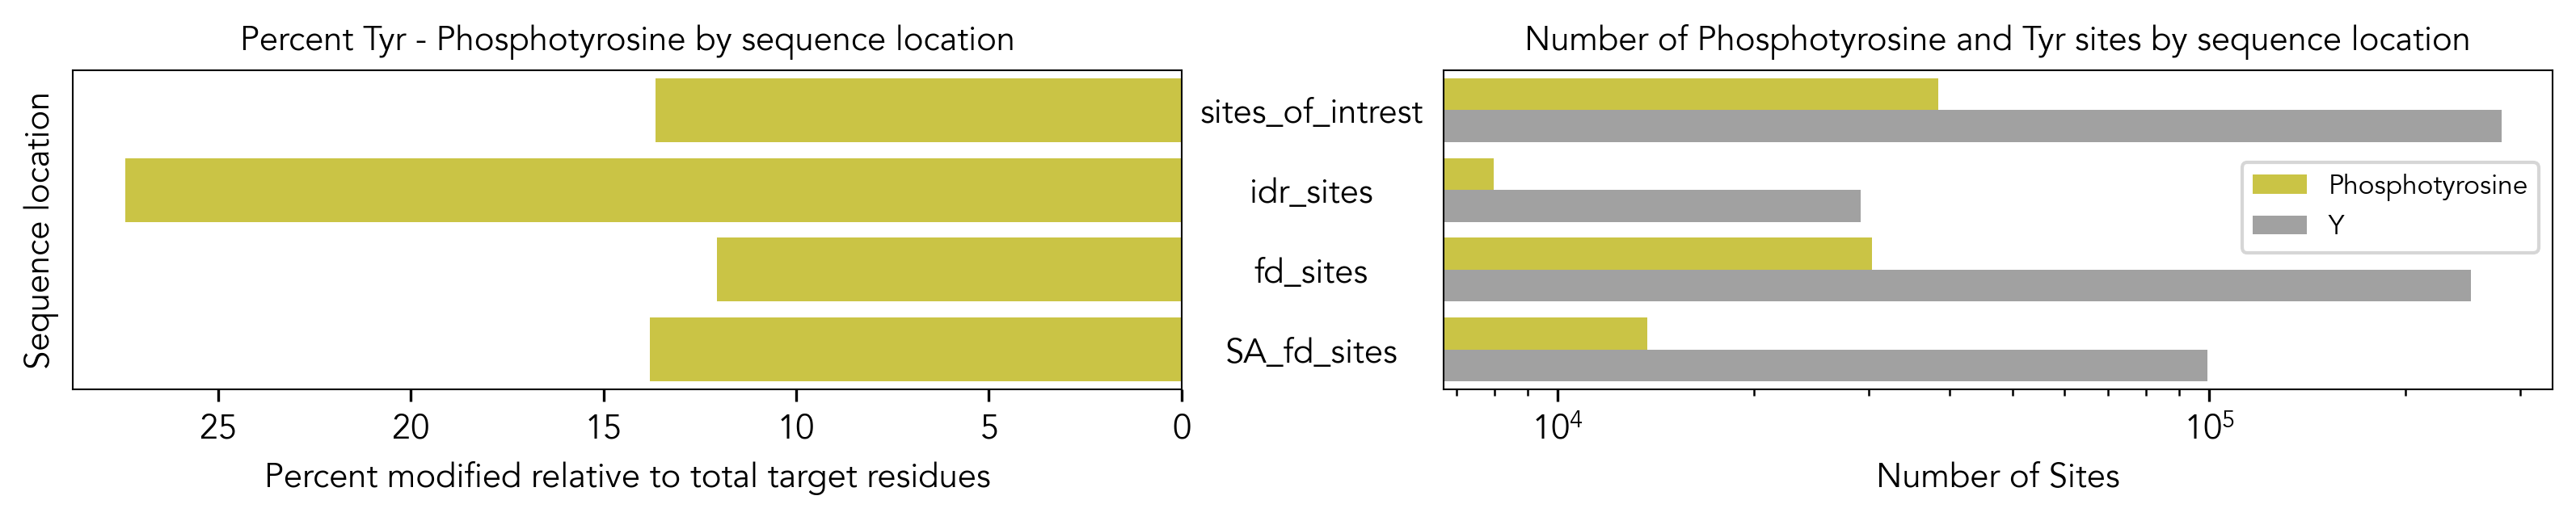

In [13]:
ptm = 'Phosphotyrosine'


residues = ", ".join([AA_letter_to_code[t] for t in PTM_target_dict[ptm]])
grouping = "_".join(PTM_target_dict[ptm])

filter_list = [ptm, grouping] # plot groups of targets

local_data = data_transformed[data_transformed.sites.isin(filter_list)]

f, ax = plt.subplots(ncols=2, figsize=(12, 3), dpi=150, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=.25)
f.tight_layout(pad=5)
# plot1
ax[0].invert_xaxis()
p1 = sns.barplot(y='variable',x='value', hue='sites' ,data=p_data_transformed[p_data_transformed['sites'] == ptm],
                 orient='h',ax=ax[0], palette=auto_ptm_palette)
ax[0].set_xlabel('Percent modified relative to total target residues')
ax[0].set_ylabel('Sequence location')
ax[0].set_yticks([])
ax[0].set_title("Percent %s - %s by sequence location" % (residues, ptm), fontsize=10)
#ax[0].set_xlim(25,0)
p1.legend_.remove()

# plot2
sns.barplot(y='variable',x='value', hue='sites',data=local_data, 
            orient='h', ax=ax[1], palette=auto_ptm_palette,log=True)
ax[1].set_xlabel('Number of Sites')
ax[1].tick_params(left=False)
ax[1].set_ylabel(None)
ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),ha='center', x=-.098, fontsize=10)
ax[1].set_title("Number of %s and %s sites by sequence location" % (ptm, residues), fontsize=10)
ax[1].legend(loc= 'center right',fontsize=8, bbox_to_anchor=(1,.57))

#### Plot all PTM data 

/Users/Garrett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


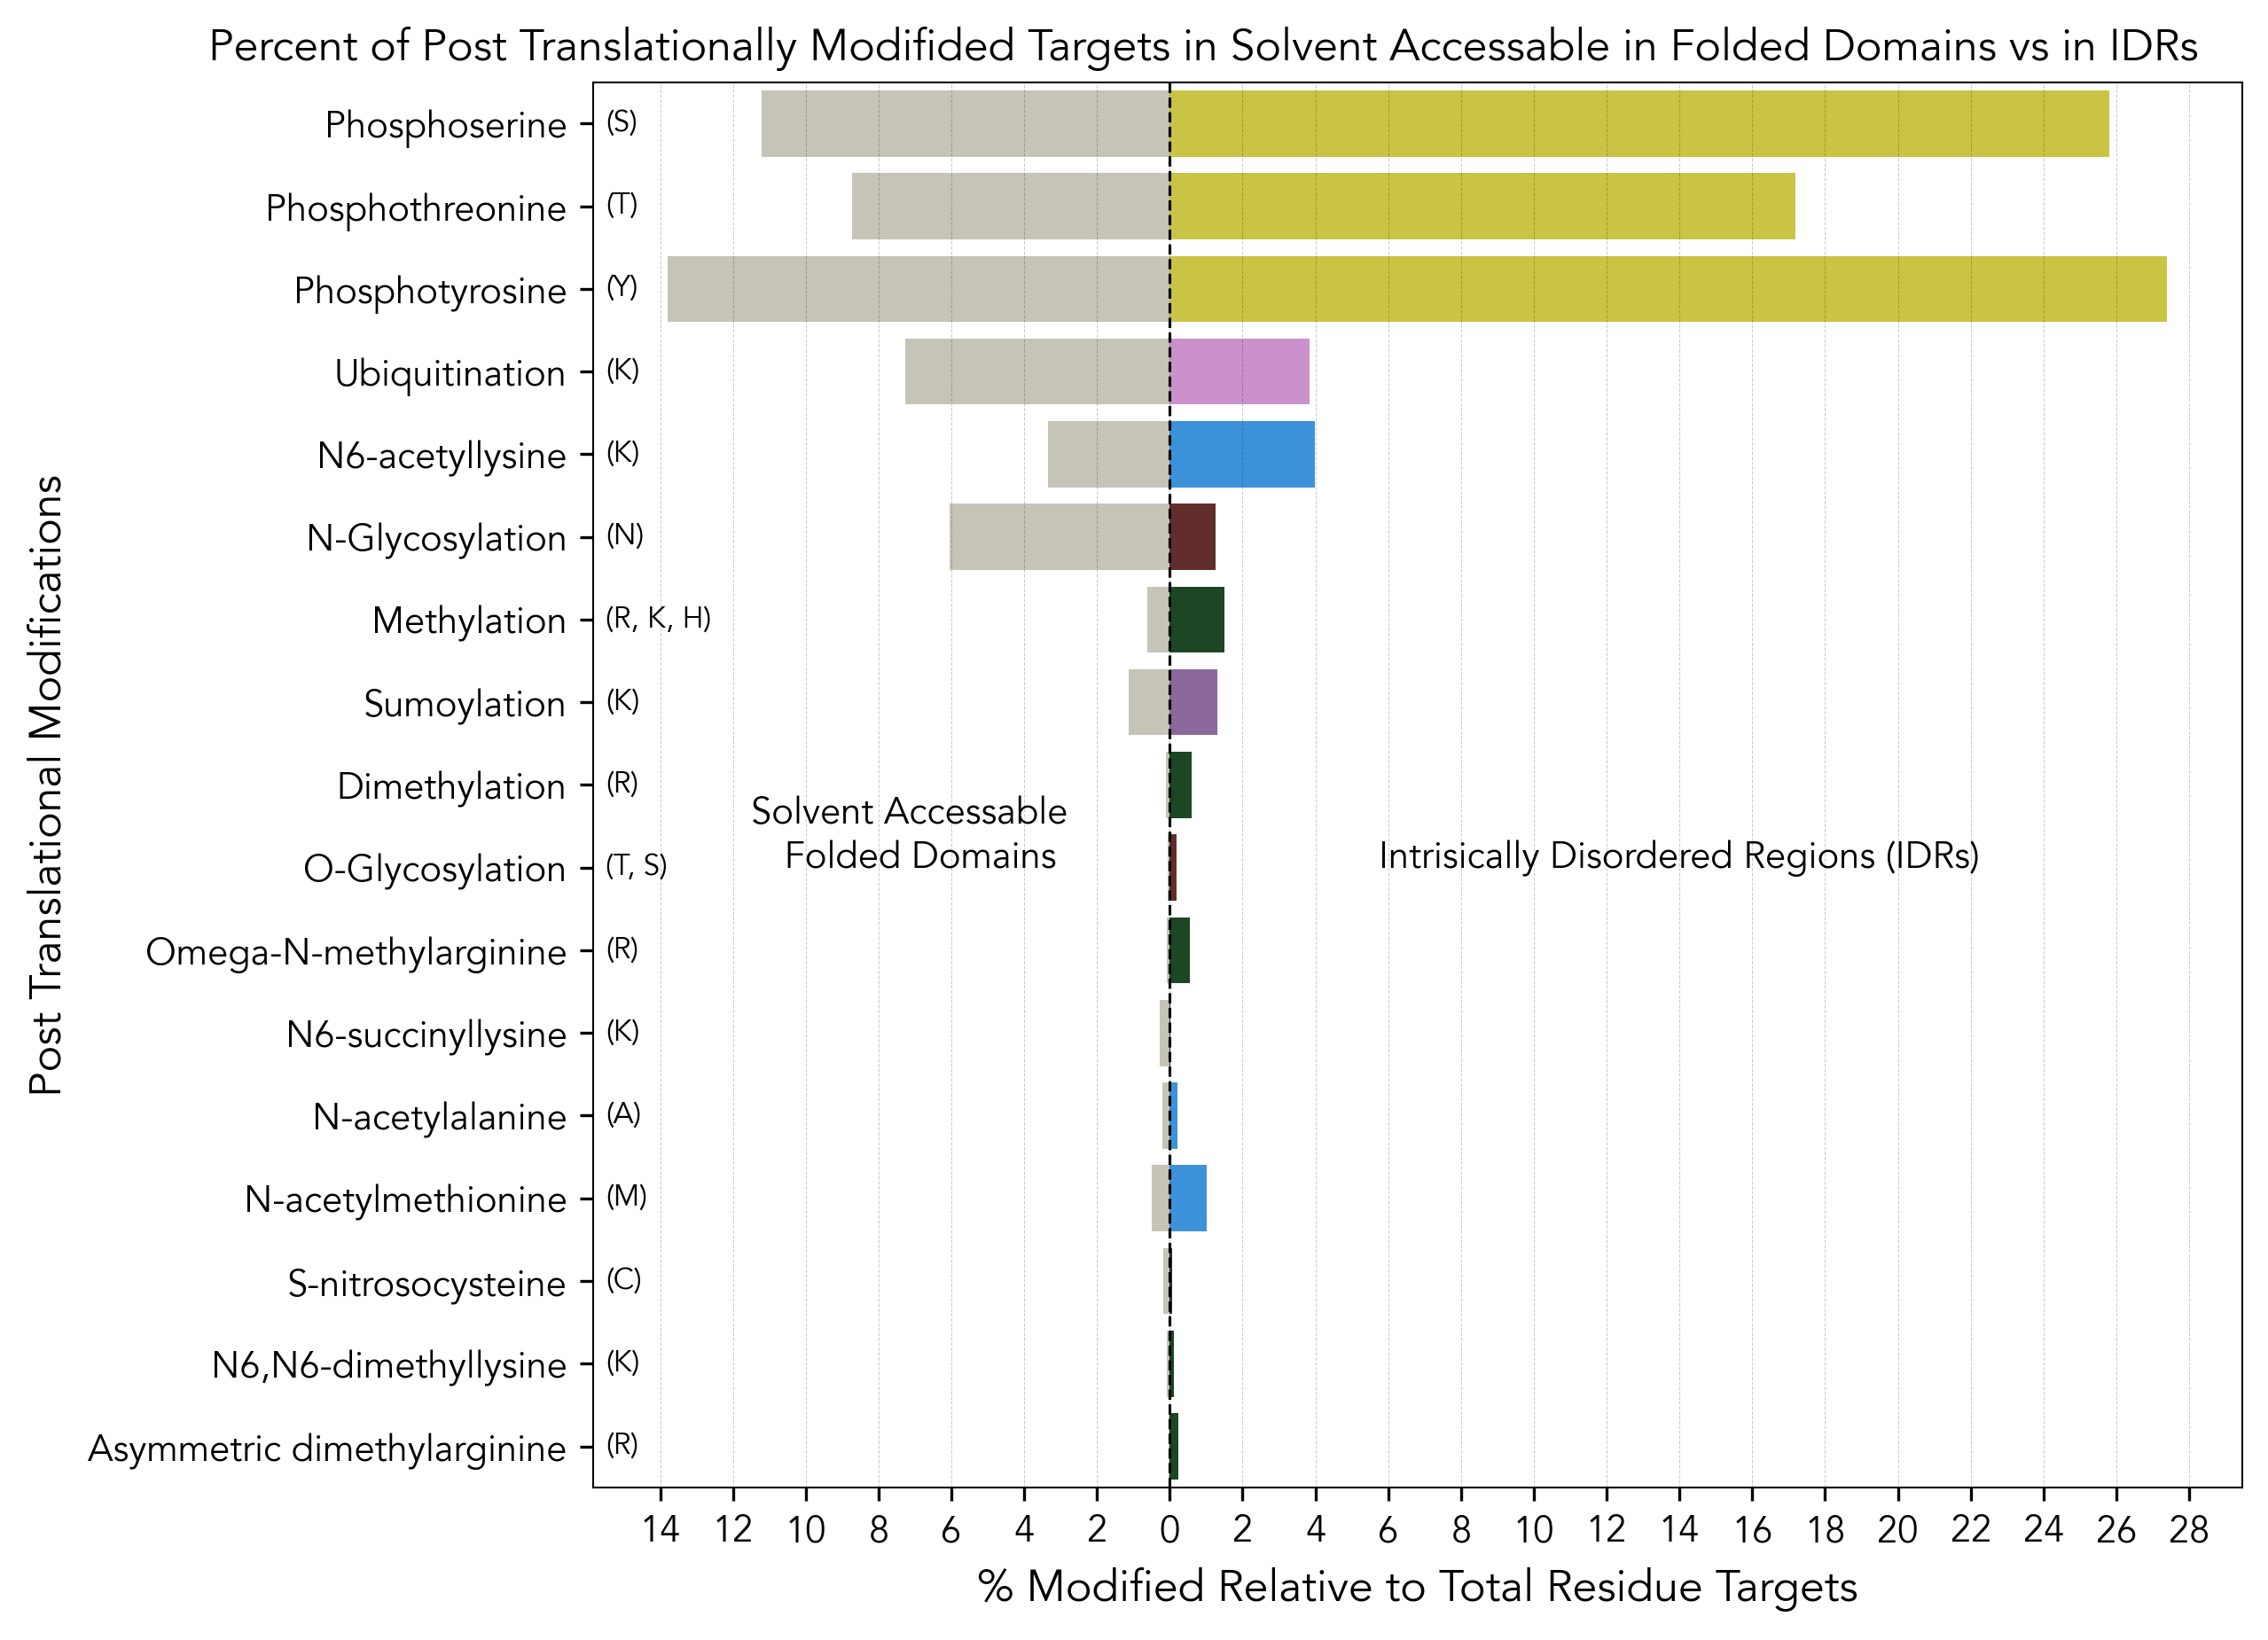

In [16]:
# make fd site value on left
local_data = p_data_transformed[p_data_transformed.variable.isin(['idr_sites','SA_fd_sites'])]
local_data['value'] = local_data.apply(lambda x: x['value']*-1 if x['variable']=='SA_fd_sites' else x['value'], axis=1)

f, ax = plt.subplots(1,1, figsize=(8, 7), dpi=150, facecolor='w', edgecolor='k')
ax.axvline(0,ls='--', c='k',lw=.75)
a1 = sns.barplot(y='sites',x='value', hue='sites',  orient='h' ,data=local_data[local_data['variable']=='idr_sites'],dodge=False,
            palette=auto_ptm_palette)
sns.barplot(y='sites',x='value', hue='variable',  orient='h' ,data=local_data[local_data['variable']=='SA_fd_sites'],
            palette=location_palette)

x_ticks = [i for i in range(-14,30,2)]
ax.set_xticks(x_ticks)
ax.set_xticklabels(np.abs(x_ticks))
target_labels = [", ".join([t for t in PTM_target_dict[l.get_text()]]) for l in ax.get_yticklabels()]
a1.legend_.remove()
ax.text(-7,9,"Solvent Accessable \n Folded Domains", ha='center')
ax.text(14,9,"Intrisically Disordered Regions (IDRs)", ha='center')
for i, t in enumerate(target_labels):
    ax.text(-15.5,i,"(%s)" % t,fontsize=8,va='center')

ax.set_xlabel('% Modified Relative to Total Residue Targets', fontsize=12)
ax.set_ylabel('Post Translational Modifications', fontsize=12)
ax.set_title('Percent of Post Translationally Modifided Targets in Solvent Accessable in Folded Domains vs in IDRs',x=.37, ha='center',fontsize=12)
ax.xaxis.grid(True, linestyle='--', color='k',alpha=.2, lw=.25)
